### Convolutional Neural Network & Computer Vision with Tensorflow

* Computer vision is a practice of writing algorithms which can discover patterns in visual data.
* Dataset (Food 101): https://www.kaggle.com/datasets/dansbecker/food-101
  * This data set is modified to perform study for only two classes (pizza and steak) using: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
  * https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
* CNN Explainer: https://poloclub.github.io/cnn-explainer/

**Getting data**

* A very crucial step at beginning  of any machine learning project is becoming one with the data
* And for a computer vision project .... usually involves visualizing many samples of data

In [6]:
# DL needs
import tensorflow as tf
import tensorflow.keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

# for os interactions
import os

In [ ]:
for dirpath,dirnames,filenames in os.walk('pizza_steak'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

**1. Building the first CNN (baseline model)**

**Steps in working with images**
* Load images
* Pre-process images (normalization,...)
* Build a CNN
* Compile CNN
* Fit CNN

**Notes:**
* A baseline is relatively simple model or existing result that we setup when beginning a ML experiment and with experimentation we try to beat the baseline.
* In DL, there is almost an infinite amount of architectures one can create. We start with simple and figure out how it works on our data, then improve it.
* `Conv2D()`
  * filters: no of filters expected at output; eg. 10, 32, 64,... (higher--> more complex model)
  * kernel_size: size of kernel; eg. 3 or (3,3)
    * lower values learn smaller features, higher values learn larger features
  * padding: 'same' (preserves original size) or 'valid' [default] (image may become compressed)
  * strides: no of steps a filter takes across an image at a time. (eg. if strides=1, filter moves across image 1 pixel at a time); default is 1

In [7]:
import pathlib

data_dir = pathlib.Path('pizza_steak/train')
class_names=np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['pizza' 'steak']


In [8]:
import matplotlib.image as mpimg
import random

def view_random_image(target_dir,target_class):
    # setup target directory
    target_folder=target_dir+"/"+target_class

    # get a random image path
    random_img=random.sample(os.listdir(target_folder),1)
    img=mpimg.imread(target_folder+"/"+random_img[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    print(f'Image shape: {img.shape}')
    return img


Image shape: (512, 384, 3)


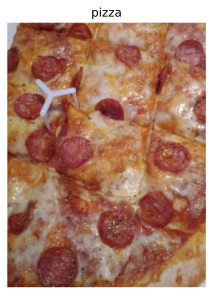

In [9]:
img=view_random_image(target_dir='pizza_steak/train',target_class='pizza')

**Data pre-processing**

* We want to convert data into batches 
* A batch is a small subset of data. Rather than look all data at the same time, a model might look at 32 images at a time. It is done because:
  * Data may not fit into the memory of your processor(GPU).
  * Trying to learn over entire may  result in model in not being able to learn very well.

Why 32?
Yann Le Cun, statement (https://en.wikipedia.org/wiki/Yann_LeCun)

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# initializing ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1/255.0)
valid_datagen=ImageDataGenerator(rescale=1/255.0)

# setup paths to data directory
train_dir='pizza_steak/train'
test_dir='pizza_steak/test'

train_data=train_datagen.flow_from_directory(directory=train_dir,
                                             batch_size=32,
                                             target_size=(224,224),
                                             class_mode="binary",
                                             seed = random_seed 
                                             )

valid_data=valid_datagen.flow_from_directory(directory=test_dir,
                                             batch_size=32,
                                             target_size=(224,224),
                                             class_mode="binary",
                                             seed = random_seed 
                                             )

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


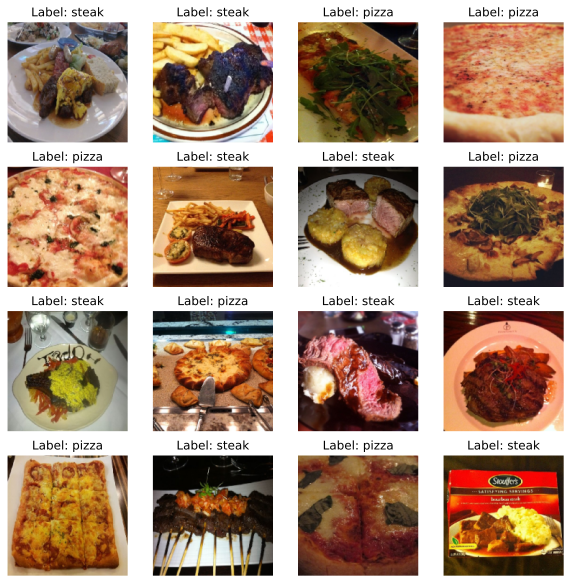

In [11]:
# visualizing the train and valid data

images, labels = train_data.__next__()
len(images), len(labels)

# Set up a grid to display images (e.g., 4x4 grid for 16 images)
num_images = min(len(images), 16)  # Display up to 16 images
plt.figure(figsize=(10, 10))

for i in range(num_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])  # Images are already normalized (0-1), so no need to rescale
    plt.title(f"Label: {class_names[int(labels[i])]}")  # Convert label to int for display
    plt.axis("off")

plt.show()

In [3]:
# Building a CNN
class tinyVGG(kr.Model):
    def __init__(self,lr=0.001,model_name='model_1',metrics=['accuracy']):
        super().__init__(name=model_name)

        # layers:

        ### CNN layers
        self.cnn_1 = tf.keras.layers.Conv2D(filters=10,
                                          kernel_size=3,
                                          input_shape=(224,224,3),name='conv_1')
        self.cnn_2 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,name='conv_2')

        ### Pool layers
        self.pool_1 = tf.keras.layers.MaxPool2D(pool_size=2,
                                                padding='valid',name='pool_1')
        
        ### CNN layers
        self.cnn_3 = tf.keras.layers.Conv2D(filters = 10, kernel_size=3,name='conv_3')    
        self.cnn_4 = tf.keras.layers.Conv2D(filters = 10, kernel_size=3,name='conv_4')    
        

        ### Pool layers
        self.pool_2 = tf.keras.layers.MaxPool2D(pool_size=2,name='pool_2')


        ### Flatten layer
        self.flatten = tf.keras.layers.Flatten(name='flatten_1')


        ### Output fully connected layer (neuron)
        self.output_layer = tf.keras.layers.Dense(units=1,name='output_layer')

        # activations
        self.activations={
            'conv_1':'relu',
            'conv_2':'relu',
            'pool_1':None,
            'conv_3':'relu',
            'conv_4':'relu',
            'pool_2':None,
            'flatten_1':None,
            'output_layer': "sigmoid"
        }

        # other hyper-params
        self.loss_function="binary_crossentropy"
        self.optimizer=kr.optimizers.Adam(learning_rate=lr)
        self.eval_metrics=metrics

        # layers
        self._layers = [self.cnn_1,
                        self.cnn_2, 
                        self.pool_1,
                        self.cnn_3,    
                        self.cnn_4,    
                        self.pool_2,
                        self.flatten,
                        self.output_layer]

        # building the model:
        self.build()

    def build(self):
        inputs=tf.keras.Input(shape=[224,224,3])
        x=self.layers[0](inputs)
        for layer in self.layers[1:]:
            x=layer(x)


    def call(self,inputs):
        ### CNN layer 1 
        self.cnn_1_o = self.cnn_1(inputs)
        self.relu_1_o =tf.nn.relu(self.cnn_1_o)

        ### CNN layer 2
        self.cnn_2_o = self.cnn_2(self.relu_1_o)
        self.relu_2_o=tf.nn.relu(self.cnn_2_o)

        ### Max pool layer 1
        self.mp_1_o=self.pool_1(self.relu_2_o)

        ### CNN layer 3 
        self.cnn_3_o = self.cnn_3(self.mp_1_o)
        self.relu_3_o=tf.nn.relu(self.cnn_3_o)

        ### CNN layer 4
        self.cnn_4_o = self.cnn_4(self.relu_3_o)
        self.relu_4_o=tf.nn.relu(self.cnn_4_o)

        ### Max pool layer 2
        self.mp_2_o=self.pool_2(self.relu_4_o)

        ### Flatten
        x=self.flatten(self.mp_2_o)

        ### Output layer
        output=tf.nn.sigmoid(self.output_layer(x))

        return output

model_1=tinyVGG(model_name='model_1')
model_1.compile(loss=model_1.loss_function,optimizer=model_1.optimizer,metrics=model_1.eval_metrics)
model_1.summary(show_trainable=True)

type(model_1)

/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ conv_1 (Conv2D)             │ (None, 222, 222, 10)  │        280 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_2 (Conv2D)             │ (None, 220, 220, 10)  │        910 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ pool_1 (MaxPooling2D)       │ (None, 110, 110, 10)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_3 (Conv2D)             │ (None, 108, 108, 10)  │        910 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_4 (Conv2D)             │ (None, 106, 106, 10)  │        910 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ pool_2 (MaxPooling2D)       │ (None, 53, 53, 10)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 28090)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ output_layer (Dense)        │ (None, 1)             │     28,091 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 31,101 (121.49 KB)

 Trainable params: 31,101 (121.49 KB)

 Non-trainable params: 0 (0.00 B)

__main__.tinyVGG

In [ ]:
len(train_data),1500/32


In [5]:
history_1=model_1.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data)
            )

Epoch 1/5


/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 767ms/step - accuracy: 0.5966 - loss: 0.6434 - val_accuracy: 0.8060 - val_loss: 0.4360
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 761ms/step - accuracy: 0.8078 - loss: 0.4296 - val_accuracy: 0.8127 - val_loss: 0.4292
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 755ms/step - accuracy: 0.8242 - loss: 0.4127 - val_accuracy: 0.8513 - val_loss: 0.3726
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 754ms/step - accuracy: 0.8351 - loss: 0.3910 - val_accuracy: 0.7500 - val_loss: 0.5584
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 754ms/step - accuracy: 0.8265 - loss: 0.4157 - val_accuracy: 0.8740 - val_loss: 0.3067


In [4]:
import sys
sys.path.append('/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/')
from important_functionalities import plot_custom_model

plot_custom_model(model_1,input_shape=[224,224,3],dpi=200,save_path='model').view()

'model.png'

In [ ]:
tV=tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=10,kernel_size=3,input_shape=(224,224,3),name='conv_1',activation='relu'),
        tf.keras.layers.Conv2D(filters=10,kernel_size=3,name='conv_2',activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2,padding='valid',name='pool_1'),
        tf.keras.layers.Conv2D(filters = 10, kernel_size=3,name='conv_3',activation='relu'),    
        tf.keras.layers.Conv2D(filters = 10, kernel_size=3,name='conv_4',activation='relu'),    
        tf.keras.layers.MaxPool2D(pool_size=2,name='pool_2'),
        tf.keras.layers.Flatten(name='flatten_1'),
        tf.keras.layers.Dense(units=1,name='output_layer',activation='sigmoid')]
)

tV.compile(loss="binary_crossentropy",optimizer=kr.optimizers.Adam(),metrics=['accuracy'])
# tV.summary()

# for layer in tV.layers:
#     print(layer.name, layer._inbound_nodes, layer._build_shapes_dict)